In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter  , PrincipalComponentAnalysis
from TemporalAbstraction import NumericalAbstraction
from FrequencyAbstraction import FourierTransformation

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9005 non-null   float64
 1   acc_y        8998 non-null   float64
 2   acc_z        8999 non-null   float64
 3   gyr_x        8984 non-null   float64
 4   gyr_y        8938 non-null   float64
 5   gyr_z        8945 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int32  
dtypes: float64(6), int32(1), object(3)
memory usage: 739.0+ KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9009 non-null   

2.4942528735632186

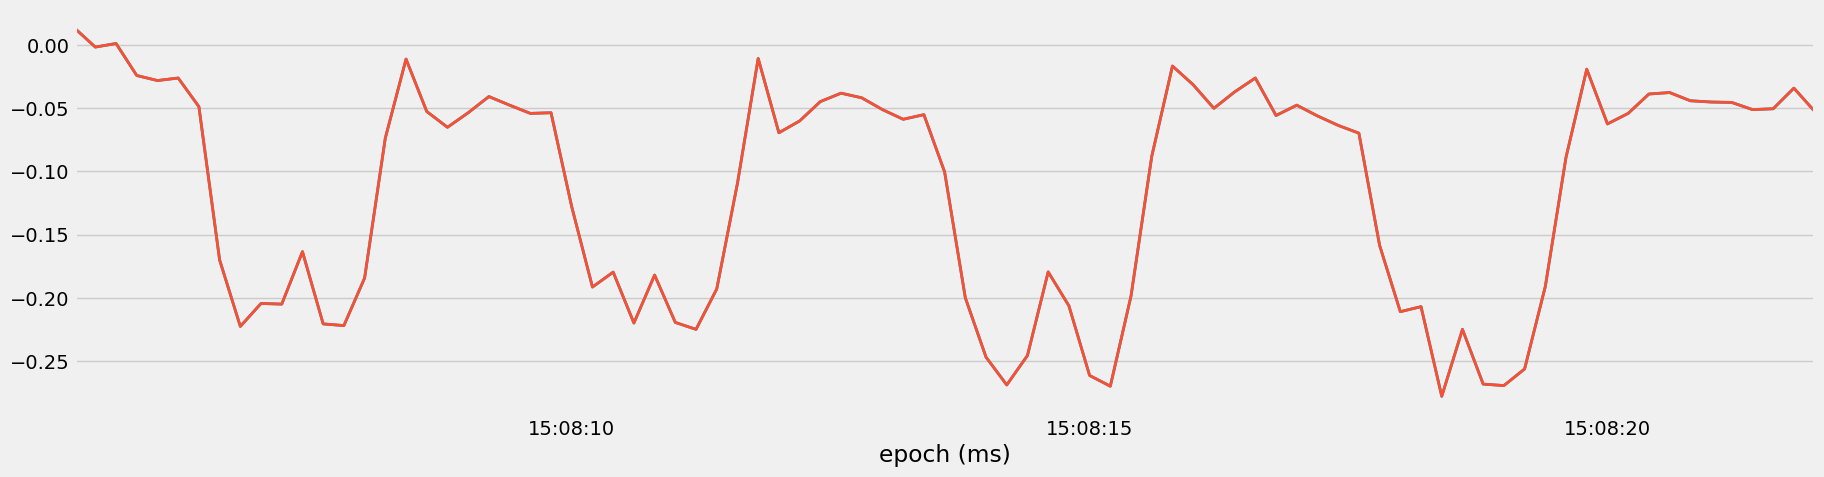

In [2]:
# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------

df = pd.read_pickle(r'../../data/interim/02_outliers_removed_chauvenets.pkl')

sensor_col = list(df.columns[:6])


plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 5)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.linewidth'] = 2

# --------------------------------------------------------------
# Dealing with missing values (imputation)
# --------------------------------------------------------------

df.info()
# Interpolation is a technique used in mathematics and statistics to estimate values between two known values. In the context of Pandas DataFrames, interpolation can be applied along rows or columns to estimate missing values based on neighboring data points.
# df['acc_x'].interpolate().isna().sum()

df[df['set']== 30]['acc_x'].plot()

for col in sensor_col:
    df[col] = df[col].interpolate()
    
df.info()

df[df['set']== 30]['acc_x'].plot()

# --------------------------------------------------------------
# Calculating set duration
# --------------------------------------------------------------

#We know that: the heavy set contains 5 repetitions, and medium set contains 10 repetitions for each exercise

#Now we need to know the duration for each set

for set in  df['set'].unique():
    
    strart = df[df['set'] == set].index[0]
    end = df[df['set'] == set].index[-1]
    
    duration = end - strart
    
    df.loc[(df['set'] == set) , 'duration'] = duration.seconds
    

duration_df =  df.groupby('category')['duration'].mean()    

duration_df[0] / 5 # so each repetition take 2.9 sec in heavy set
duration_df[1] / 10 # so each repetition take 2.4 sec in medium set

In [3]:
df_lowpass = df.copy()

ohp


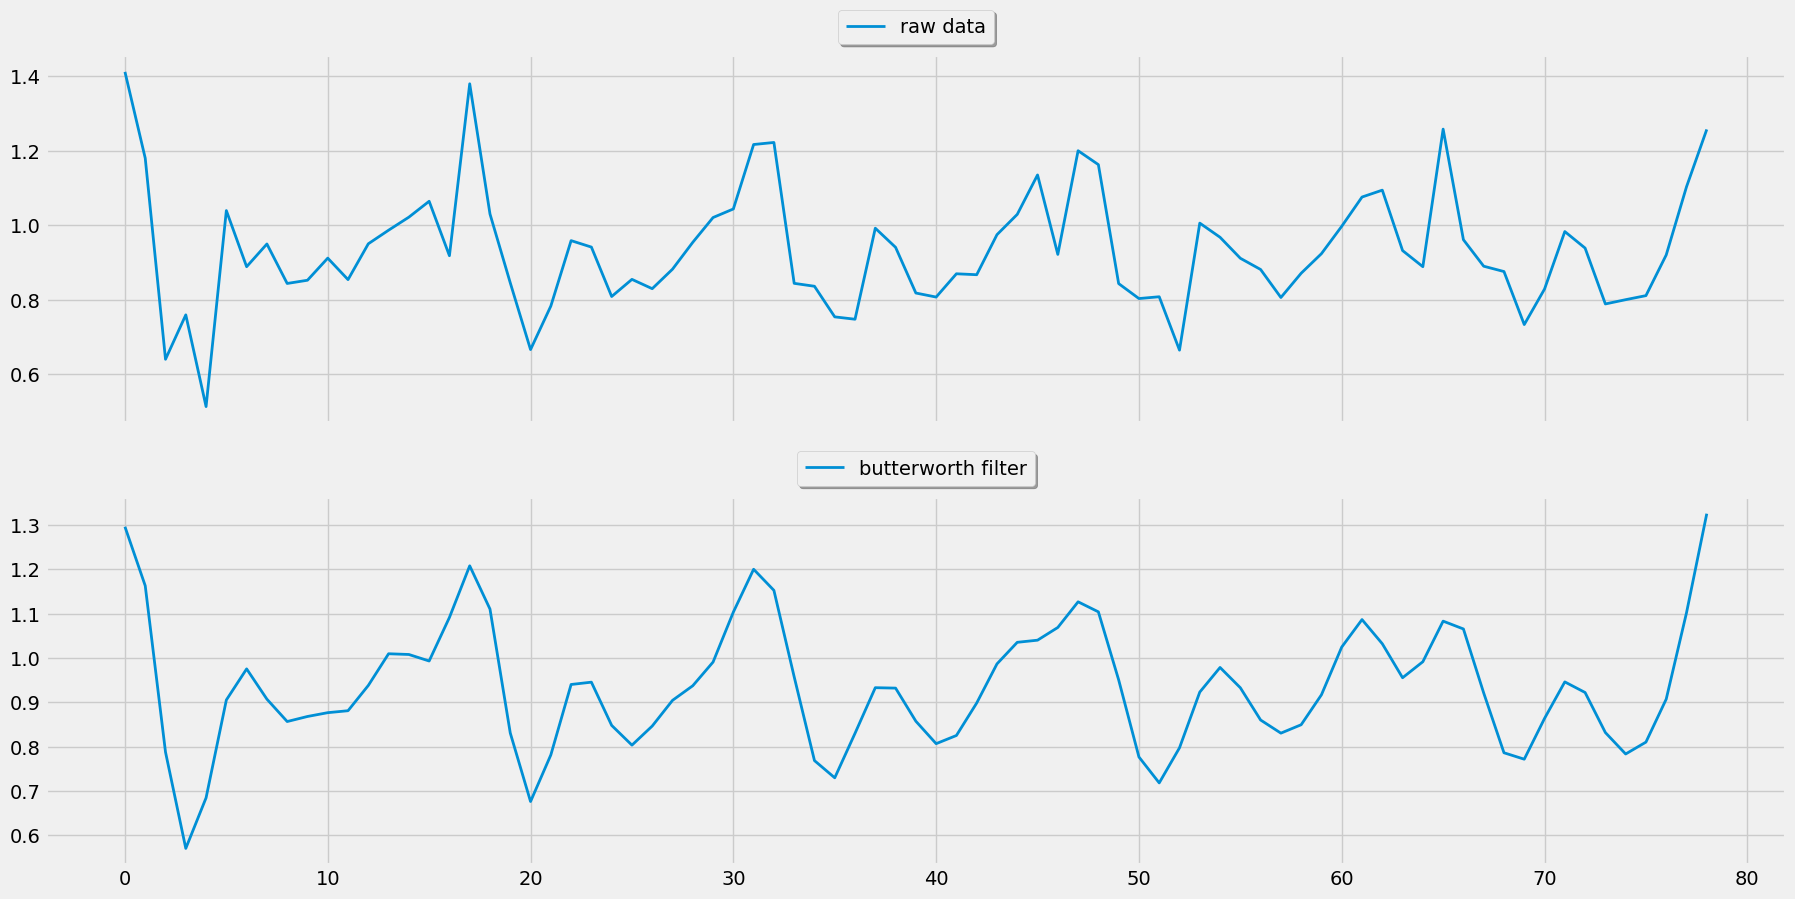

In [4]:


LowPass = LowPassFilter()

sampling_frq = 1000 / 200 # # because we are taking the record every 200 ms, so that line calculates number of repetition in 1 sec

cutoff_frq = 1.3 # the low cutoff frequency, meaning more smoothing in signal

LowPass.low_pass_filter(df_lowpass , 'acc_y' , sampling_frq , cutoff_frq)

subset = df_lowpass[df_lowpass["set"] == 45]
print(subset["label"][0])

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
ax[0].plot(subset["acc_y"].reset_index(drop=True), label="raw data")
ax[1].plot(subset["acc_y_lowpass"].reset_index(drop=True), label="butterworth filter")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)

In [5]:
for col in sensor_col:
    df_lowpass = LowPass.low_pass_filter(df_lowpass, col, sampling_frq, cutoff_frq, order=5)
    df_lowpass[col] = df_lowpass[col + "_lowpass"]
    del df_lowpass[col + "_lowpass"]

<AxesSubplot: xlabel='epoch (ms)'>

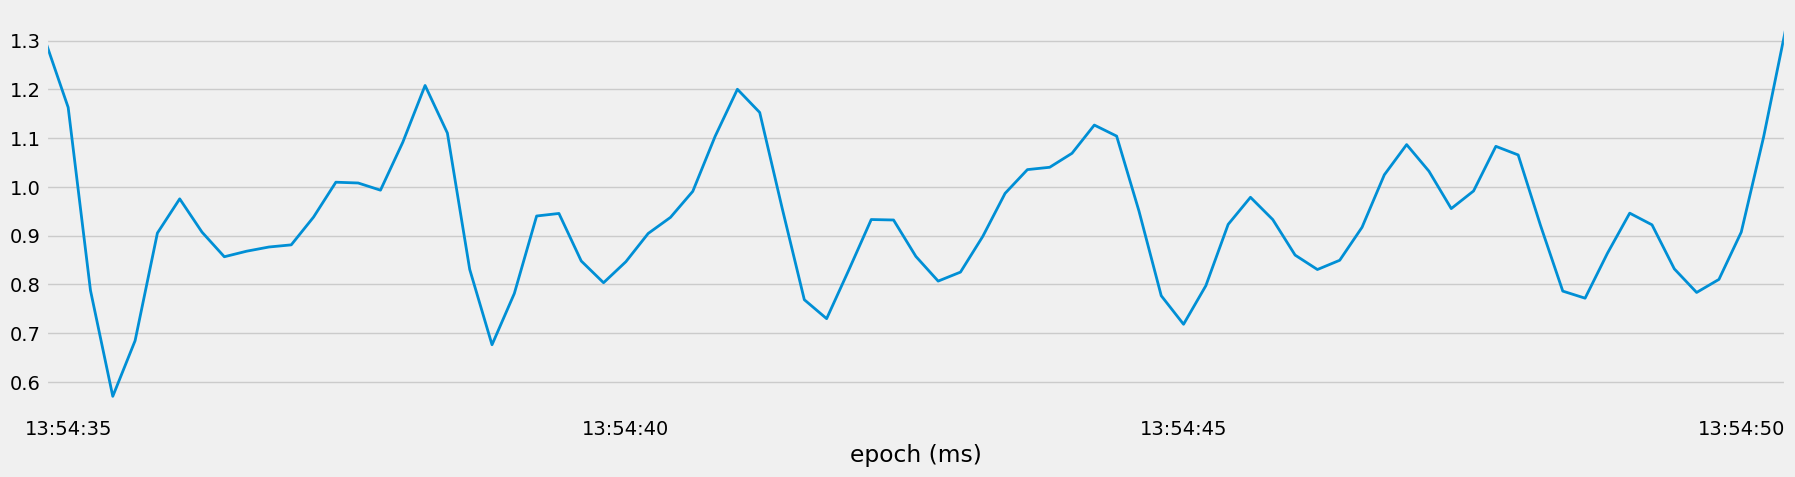

In [8]:
df_lowpass[df_lowpass["set"] == 45]['acc_y'].plot()

In [10]:
# --------------------------------------------------------------
# Principal component analysis PCA
# --------------------------------------------------------------

In [9]:
df_pca = df_lowpass.copy()
PCA = PrincipalComponentAnalysis()

In [10]:
pc_values =  PCA.determine_pc_explained_variance(df_pca , sensor_col)

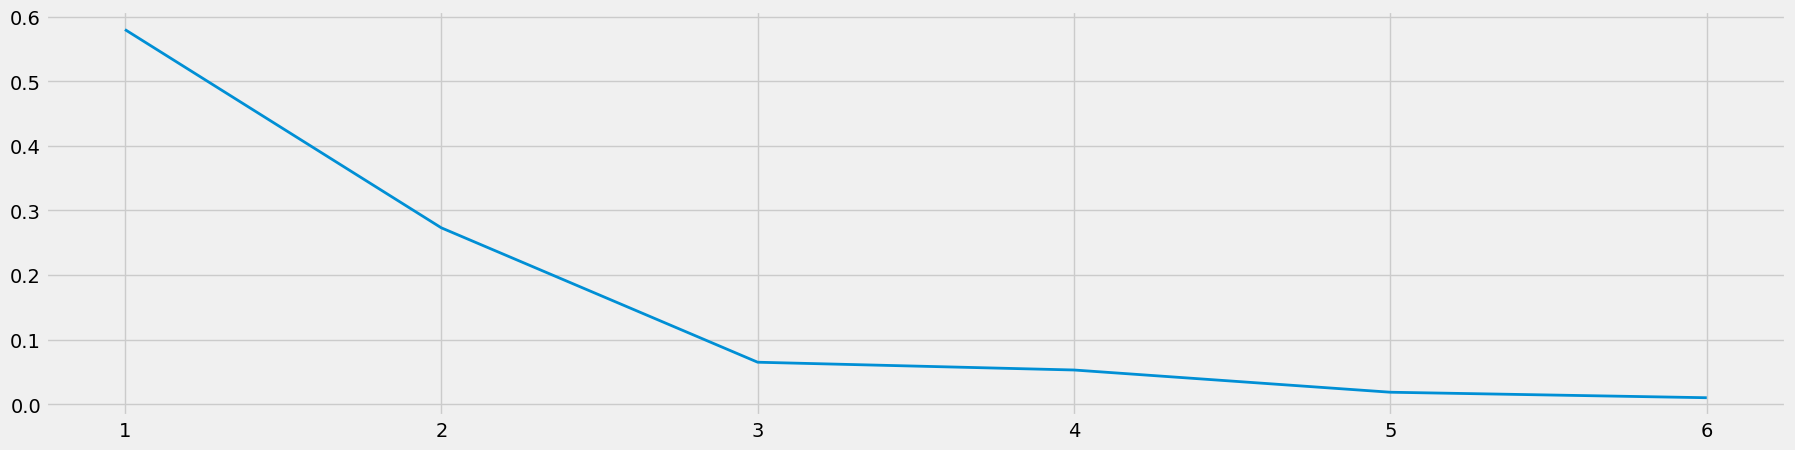

In [11]:
plt.plot(range(1, 7) , pc_values)

In [12]:
df_pca = PCA.apply_pca(df_pca , sensor_col , 3 )

In [13]:
df_pca

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3
epoch (ms),,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013503,0.977003,-0.071001,-1.886218,2.438803,0.937522,B,bench,heavy,30,16.0,-0.315889,-0.075461,0.072243
2019-01-11 15:08:05.400,0.008515,0.973169,-0.066481,-0.367396,0.439794,0.178360,B,bench,heavy,30,16.0,-0.314873,-0.073888,0.069825
2019-01-11 15:08:05.600,-0.008450,0.966879,-0.071895,4.320608,-2.083978,-1.217263,B,bench,heavy,30,16.0,-0.314236,-0.080343,0.066219
2019-01-11 15:08:05.800,-0.024359,0.962244,-0.084774,4.737252,-3.456339,-0.678205,B,bench,heavy,30,16.0,-0.314356,-0.090852,0.061839
2019-01-11 15:08:06.000,-0.022092,0.959572,-0.096776,0.808615,-1.194575,-1.783172,B,bench,heavy,30,16.0,-0.313630,-0.097479,0.062974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.043276,-0.988153,-0.062545,2.032956,-4.019557,0.196986,E,row,medium,90,19.0,0.349351,-0.148450,-0.053031
2019-01-20 17:33:27.200,-0.041403,-1.053448,-0.064530,-2.967835,-2.660315,1.584934,E,row,medium,90,19.0,0.371610,-0.151455,-0.058498
2019-01-20 17:33:27.400,-0.048048,-1.044737,-0.065951,-0.043109,-2.022091,1.155930,E,row,medium,90,19.0,0.368098,-0.153153,-0.058772


<AxesSubplot: xlabel='epoch (ms)'>

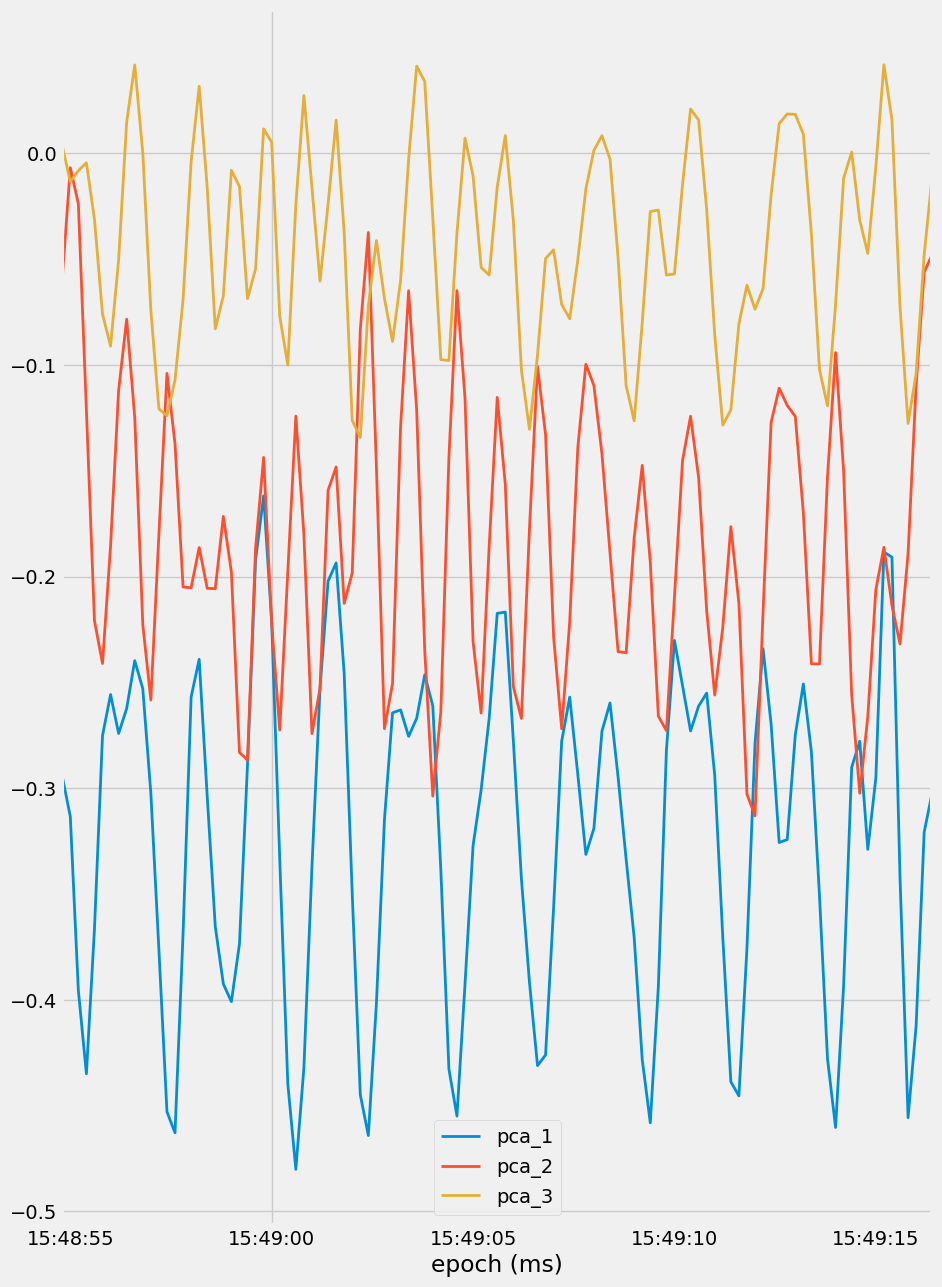

In [14]:
subset = df_pca[df_pca["set"] == 35] 

subset[['pca_1' , 'pca_2' , 'pca_3']].plot(figsize = (10,15))

In [15]:
df_squares = df_pca.copy()

acc_r = df_squares['acc_x'] **2 + df_squares['acc_y'] **2 +df_squares['acc_z'] **2 
gyr_r = df_squares['gyr_x'] **2 + df_squares['gyr_y'] **2 +df_squares['gyr_z'] **2 


df_squares['acc_r'] = np.sqrt(acc_r)
df_squares['gyr_r'] = np.sqrt(gyr_r)



In [18]:
df_squares

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3,acc_r,gyr_r
epoch (ms),,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013503,0.977003,-0.071001,-1.886218,2.438803,0.937522,B,bench,heavy,30,16.0,-0.315889,-0.075461,0.072243,0.979672,3.222503
2019-01-11 15:08:05.400,0.008515,0.973169,-0.066481,-0.367396,0.439794,0.178360,B,bench,heavy,30,16.0,-0.314873,-0.073888,0.069825,0.975474,0.600176
2019-01-11 15:08:05.600,-0.008450,0.966879,-0.071895,4.320608,-2.083978,-1.217263,B,bench,heavy,30,16.0,-0.314236,-0.080343,0.066219,0.969585,4.948974
2019-01-11 15:08:05.800,-0.024359,0.962244,-0.084774,4.737252,-3.456339,-0.678205,B,bench,heavy,30,16.0,-0.314356,-0.090852,0.061839,0.966278,5.903203
2019-01-11 15:08:06.000,-0.022092,0.959572,-0.096776,0.808615,-1.194575,-1.783172,B,bench,heavy,30,16.0,-0.313630,-0.097479,0.062974,0.964693,2.293593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.043276,-0.988153,-0.062545,2.032956,-4.019557,0.196986,E,row,medium,90,19.0,0.349351,-0.148450,-0.053031,0.991076,4.508719
2019-01-20 17:33:27.200,-0.041403,-1.053448,-0.064530,-2.967835,-2.660315,1.584934,E,row,medium,90,19.0,0.371610,-0.151455,-0.058498,1.056234,4.289212
2019-01-20 17:33:27.400,-0.048048,-1.044737,-0.065951,-0.043109,-2.022091,1.155930,E,row,medium,90,19.0,0.368098,-0.153153,-0.058772,1.047919,2.329568


array([<Axes: xlabel='epoch (ms)'>, <Axes: xlabel='epoch (ms)'>],
      dtype=object)

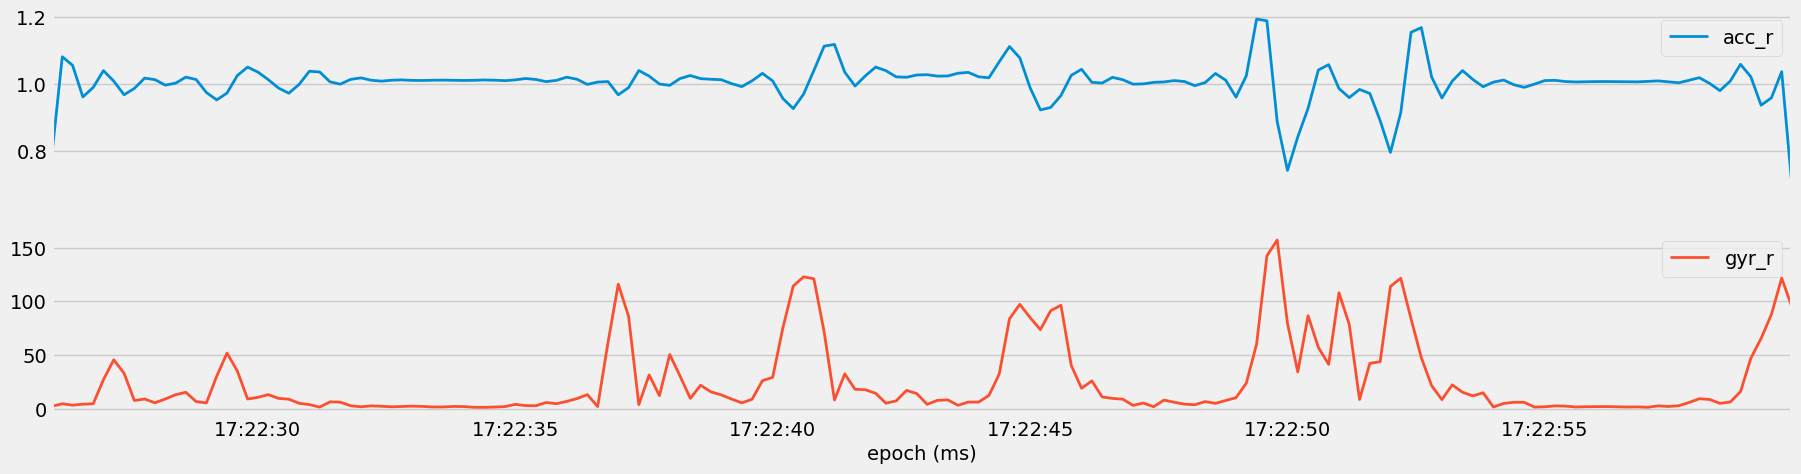

In [19]:
subset = df_squares[df_pca["set"] == 18] 

subset[['acc_r' , 'gyr_r' ]].plot(subplots = True)

In [20]:
df_squares

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3,acc_r,gyr_r
epoch (ms),,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013503,0.977003,-0.071001,-1.886218,2.438803,0.937522,B,bench,heavy,30,16.0,-0.315889,-0.075461,0.072243,0.979672,3.222503
2019-01-11 15:08:05.400,0.008515,0.973169,-0.066481,-0.367396,0.439794,0.178360,B,bench,heavy,30,16.0,-0.314873,-0.073888,0.069825,0.975474,0.600176
2019-01-11 15:08:05.600,-0.008450,0.966879,-0.071895,4.320608,-2.083978,-1.217263,B,bench,heavy,30,16.0,-0.314236,-0.080343,0.066219,0.969585,4.948974
2019-01-11 15:08:05.800,-0.024359,0.962244,-0.084774,4.737252,-3.456339,-0.678205,B,bench,heavy,30,16.0,-0.314356,-0.090852,0.061839,0.966278,5.903203
2019-01-11 15:08:06.000,-0.022092,0.959572,-0.096776,0.808615,-1.194575,-1.783172,B,bench,heavy,30,16.0,-0.313630,-0.097479,0.062974,0.964693,2.293593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.043276,-0.988153,-0.062545,2.032956,-4.019557,0.196986,E,row,medium,90,19.0,0.349351,-0.148450,-0.053031,0.991076,4.508719
2019-01-20 17:33:27.200,-0.041403,-1.053448,-0.064530,-2.967835,-2.660315,1.584934,E,row,medium,90,19.0,0.371610,-0.151455,-0.058498,1.056234,4.289212
2019-01-20 17:33:27.400,-0.048048,-1.044737,-0.065951,-0.043109,-2.022091,1.155930,E,row,medium,90,19.0,0.368098,-0.153153,-0.058772,1.047919,2.329568


# Temporal abstraction

In [16]:
# Rolling averages are commonly used to smooth out short-term fluctuations or noise in time-series data and highlight longer-term trends or patterns.
# They are particularly useful for identifying patterns that might not be immediately apparent in raw data, especially when dealing with data that contains significant variability or noise.

df_temporal =  df_squares.copy() 
df_temporal

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3,acc_r,gyr_r
epoch (ms),,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013503,0.977003,-0.071001,-1.886218,2.438803,0.937522,B,bench,heavy,30,16.0,-0.315889,-0.075461,0.072243,0.979672,3.222503
2019-01-11 15:08:05.400,0.008515,0.973169,-0.066481,-0.367396,0.439794,0.178360,B,bench,heavy,30,16.0,-0.314873,-0.073888,0.069825,0.975474,0.600176
2019-01-11 15:08:05.600,-0.008450,0.966879,-0.071895,4.320608,-2.083978,-1.217263,B,bench,heavy,30,16.0,-0.314236,-0.080343,0.066219,0.969585,4.948974
2019-01-11 15:08:05.800,-0.024359,0.962244,-0.084774,4.737252,-3.456339,-0.678205,B,bench,heavy,30,16.0,-0.314356,-0.090852,0.061839,0.966278,5.903203
2019-01-11 15:08:06.000,-0.022092,0.959572,-0.096776,0.808615,-1.194575,-1.783172,B,bench,heavy,30,16.0,-0.313630,-0.097479,0.062974,0.964693,2.293593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.043276,-0.988153,-0.062545,2.032956,-4.019557,0.196986,E,row,medium,90,19.0,0.349351,-0.148450,-0.053031,0.991076,4.508719
2019-01-20 17:33:27.200,-0.041403,-1.053448,-0.064530,-2.967835,-2.660315,1.584934,E,row,medium,90,19.0,0.371610,-0.151455,-0.058498,1.056234,4.289212
2019-01-20 17:33:27.400,-0.048048,-1.044737,-0.065951,-0.043109,-2.022091,1.155930,E,row,medium,90,19.0,0.368098,-0.153153,-0.058772,1.047919,2.329568


In [17]:
sensor_col = sensor_col + ['acc_r' , 'gyr_r']

In [18]:
NumAbs = NumericalAbstraction()

In [25]:
# NumAbs.abstract_numerical(df_temporal , sensor_col , window_size=5 ,aggregation_function= 'mean' )

In [19]:
# we need to make moving average on each set because each set may containing different label (exercise)

df_temporal_list = []
for set in df_temporal['set'].unique():
    subset = df_temporal[df_temporal['set'] == set].copy()
    
    for col in sensor_col:
        subset = NumAbs.abstract_numerical(subset , sensor_col , window_size=5 ,aggregation_function= 'mean' )
        subset = NumAbs.abstract_numerical(subset , sensor_col , window_size=5 ,aggregation_function= 'std' )

    df_temporal_list.append(subset)



In [20]:
df_temporal_list

[                            acc_x     acc_y     acc_z     gyr_x     gyr_y  \
 epoch (ms)                                                                  
 2019-01-11 15:08:05.200  0.013503  0.977003 -0.071001 -1.886218  2.438803   
 2019-01-11 15:08:05.400  0.008515  0.973169 -0.066481 -0.367396  0.439794   
 2019-01-11 15:08:05.600 -0.008450  0.966879 -0.071895  4.320608 -2.083978   
 2019-01-11 15:08:05.800 -0.024359  0.962244 -0.084774  4.737252 -3.456339   
 2019-01-11 15:08:06.000 -0.022092  0.959572 -0.096776  0.808615 -1.194575   
 ...                           ...       ...       ...       ...       ...   
 2019-01-11 15:08:21.200 -0.048804  0.973073 -0.063251 -0.772780 -3.312691   
 2019-01-11 15:08:21.400 -0.046346  0.967479 -0.056586  0.446835 -2.624468   
 2019-01-11 15:08:21.600 -0.047800  0.963648 -0.054994  2.689230 -2.259303   
 2019-01-11 15:08:21.800 -0.047109  0.962196 -0.064949  2.793593 -2.156319   
 2019-01-11 15:08:22.000 -0.033526  0.967265 -0.076666  0.771060

In [21]:
df_temporal=  pd.concat(df_temporal_list)

<AxesSubplot: xlabel='epoch (ms)'>

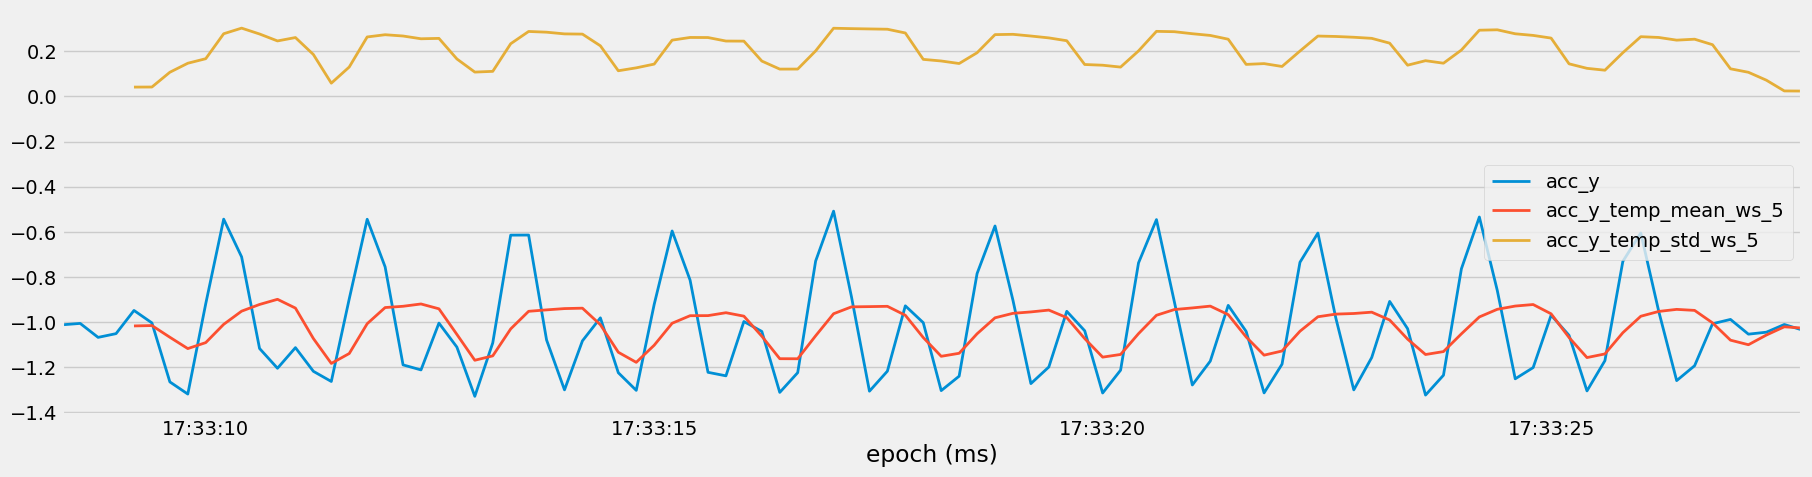

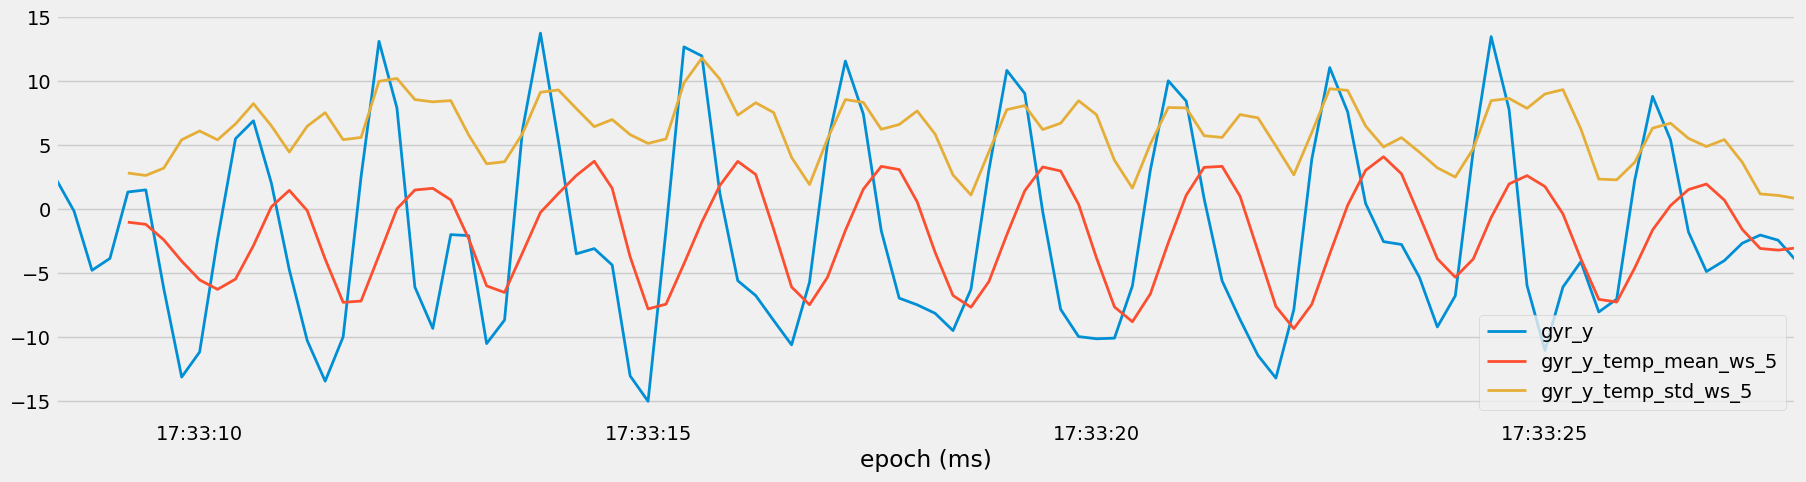

In [22]:
subset[['acc_y' , 'acc_y_temp_mean_ws_5' , 'acc_y_temp_std_ws_5']].plot()
subset[['gyr_y' , 'gyr_y_temp_mean_ws_5' , 'gyr_y_temp_std_ws_5']].plot()


In [23]:
df_temporal.columns

Index(['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'participant',
       'label', 'category', 'set', 'duration', 'pca_1', 'pca_2', 'pca_3',
       'acc_r', 'gyr_r', 'acc_x_temp_mean_ws_5', 'acc_y_temp_mean_ws_5',
       'acc_z_temp_mean_ws_5', 'gyr_x_temp_mean_ws_5', 'gyr_y_temp_mean_ws_5',
       'gyr_z_temp_mean_ws_5', 'acc_r_temp_mean_ws_5', 'gyr_r_temp_mean_ws_5',
       'acc_x_temp_std_ws_5', 'acc_y_temp_std_ws_5', 'acc_z_temp_std_ws_5',
       'gyr_x_temp_std_ws_5', 'gyr_y_temp_std_ws_5', 'gyr_z_temp_std_ws_5',
       'acc_r_temp_std_ws_5', 'gyr_r_temp_std_ws_5'],
      dtype='object')

# Frequency features
# The idea of a Fourier transformation is that any sequence of measurements we perform can be represented by a combination of sinusoid functionswith different frequencies 

#DFT can provide insight into patterns and trends that would not otherwise be visible. Additionally, the DFT can be used to reduce noise, allowing for more accurate models.

In [26]:
df_frq = df_temporal.copy().reset_index()
#df_frq

In [29]:
FreqAbs = FourierTransformation()

sampling_frq = int(1000 / 200)
window_size = int (2800 / 200)

In [30]:
FreqAbs.abstract_frequency(df_frq , ['acc_y'] , window_size , sampling_frq)

,epoch (ms),acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,...,acc_y_freq_weighted,acc_y_pse,acc_y_freq_0.0_Hz_ws_14,acc_y_freq_0.357_Hz_ws_14,acc_y_freq_0.714_Hz_ws_14,acc_y_freq_1.071_Hz_ws_14,acc_y_freq_1.429_Hz_ws_14,acc_y_freq_1.786_Hz_ws_14,acc_y_freq_2.143_Hz_ws_14,acc_y_freq_2.5_Hz_ws_14
0,2019-01-11 15:08:05.200,0.013503,0.977003,-0.071001,-1.886218,2.438803,0.937522,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-11 15:08:05.400,0.008515,0.973169,-0.066481,-0.367396,0.439794,0.178360,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-11 15:08:05.600,-0.008450,0.966879,-0.071895,4.320608,-2.083978,-1.217263,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-11 15:08:05.800,-0.024359,0.962244,-0.084774,4.737252,-3.456339,-0.678205,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-11 15:08:06.000,-0.022092,0.959572,-0.096776,0.808615,-1.194575,-1.783172,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9004,2019-01-20 17:33:27.000,-0.043276,-0.988153,-0.062545,2.032956,-4.019557,0.196986,E,row,medium,...,-0.366246,0.080086,-15.086721,0.169773,1.260702,0.908251,0.370038,0.284737,0.272604,0.270130
9005,2019-01-20 17:33:27.200,-0.041403,-1.053448,-0.064530,-2.967835,-2.660315,1.584934,E,row,medium,...,-0.189618,0.098206,-15.605886,-0.499724,1.034515,-1.036798,0.960714,0.363849,0.279607,0.252243
9006,2019-01-20 17:33:27.400,-0.048048,-1.044737,-0.065951,-0.043109,-2.022091,1.155930,E,row,medium,...,0.083718,0.054012,-15.790817,-0.732594,0.519170,-1.087010,-0.032387,-0.036956,-0.056240,-0.063536
9007,2019-01-20 17:33:27.600,-0.050572,-1.010599,-0.060327,3.033517,-2.427441,0.279918,E,row,medium,...,0.116557,0.041741,-15.550088,-0.433942,0.006282,0.624310,-0.794175,-0.262326,-0.198431,-0.178484


<AxesSubplot: >

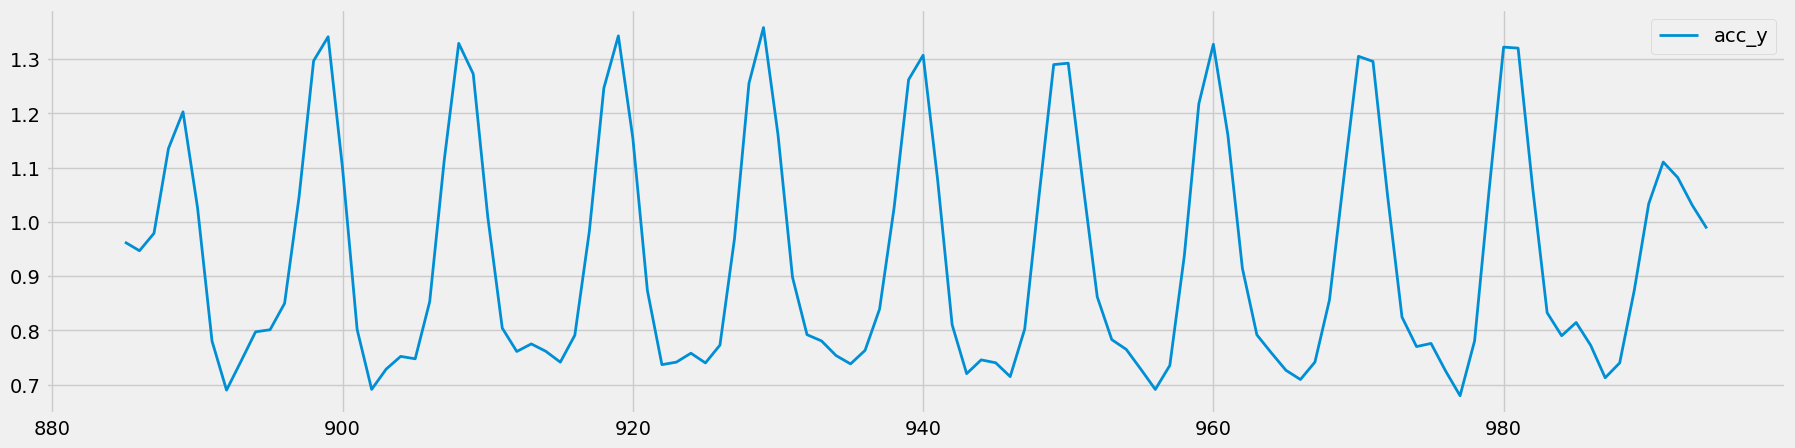

In [31]:
subset = df_frq[df_frq['set'] == 15]
subset[['acc_y']].plot()

In [32]:
subset.columns

Index(['epoch (ms)', 'acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z',
       'participant', 'label', 'category', 'set', 'duration', 'pca_1', 'pca_2',
       'pca_3', 'acc_r', 'gyr_r', 'acc_x_temp_mean_ws_5',
       'acc_y_temp_mean_ws_5', 'acc_z_temp_mean_ws_5', 'gyr_x_temp_mean_ws_5',
       'gyr_y_temp_mean_ws_5', 'gyr_z_temp_mean_ws_5', 'acc_r_temp_mean_ws_5',
       'gyr_r_temp_mean_ws_5', 'acc_x_temp_std_ws_5', 'acc_y_temp_std_ws_5',
       'acc_z_temp_std_ws_5', 'gyr_x_temp_std_ws_5', 'gyr_y_temp_std_ws_5',
       'gyr_z_temp_std_ws_5', 'acc_r_temp_std_ws_5', 'gyr_r_temp_std_ws_5',
       'acc_y_max_freq', 'acc_y_freq_weighted', 'acc_y_pse',
       'acc_y_freq_0.0_Hz_ws_14', 'acc_y_freq_0.357_Hz_ws_14',
       'acc_y_freq_0.714_Hz_ws_14', 'acc_y_freq_1.071_Hz_ws_14',
       'acc_y_freq_1.429_Hz_ws_14', 'acc_y_freq_1.786_Hz_ws_14',
       'acc_y_freq_2.143_Hz_ws_14', 'acc_y_freq_2.5_Hz_ws_14'],
      dtype='object')

<AxesSubplot: >

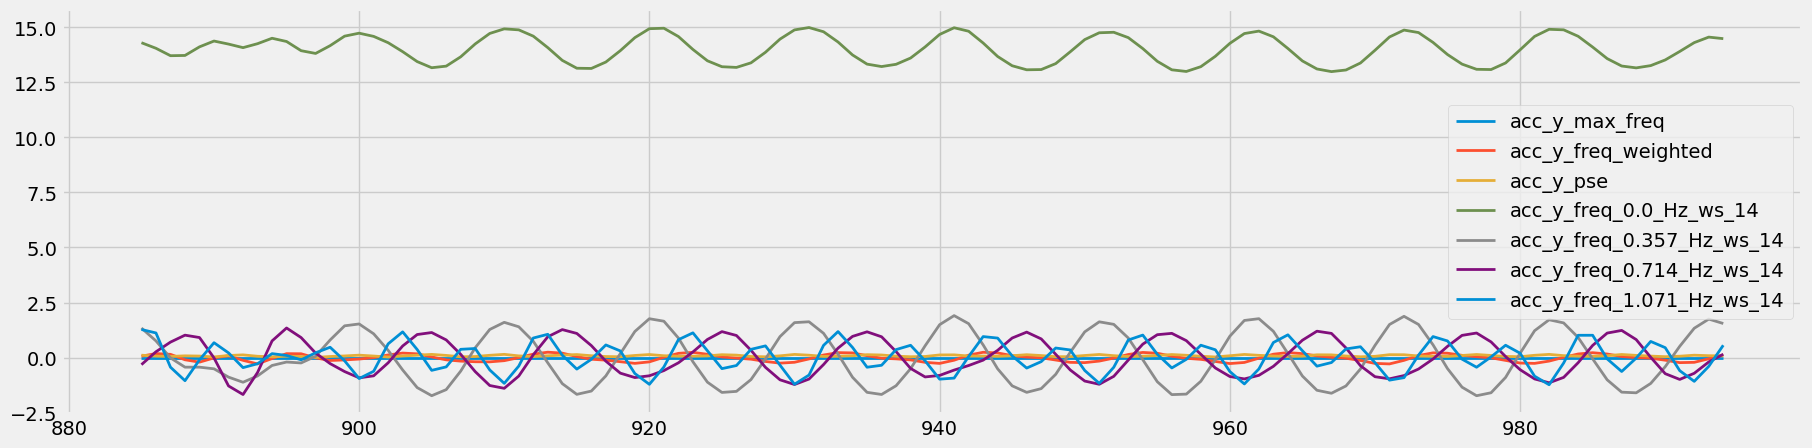

In [33]:
# Fourier transformation  abstracted the sign into its basic constituent elements

subset[['acc_y_max_freq', 'acc_y_freq_weighted', 'acc_y_pse',
       'acc_y_freq_0.0_Hz_ws_14', 'acc_y_freq_0.357_Hz_ws_14',
       'acc_y_freq_0.714_Hz_ws_14', 'acc_y_freq_1.071_Hz_ws_14']].plot()

In [35]:
df_freq_list = []
for set in df_frq['set'].unique():
    print(f'Applying Fourier transformation to set {set}')
    subset = df_frq[df_frq['set'] == set].reset_index(drop = True).copy()
    
    subset = FreqAbs.abstract_frequency(subset , sensor_col , window_size , sampling_frq)
    

    df_freq_list.append(subset)

Applying Fourier transformation to set 30
Applying Fourier transformation to set 1
Applying Fourier transformation to set 31
Applying Fourier transformation to set 3
Applying Fourier transformation to set 9
Applying Fourier transformation to set 32
Applying Fourier transformation to set 10
Applying Fourier transformation to set 33
Applying Fourier transformation to set 11
Applying Fourier transformation to set 34
Applying Fourier transformation to set 35
Applying Fourier transformation to set 15
Applying Fourier transformation to set 36
Applying Fourier transformation to set 16
Applying Fourier transformation to set 37
Applying Fourier transformation to set 17
Applying Fourier transformation to set 27
Applying Fourier transformation to set 38
Applying Fourier transformation to set 28
Applying Fourier transformation to set 29
Applying Fourier transformation to set 6
Applying Fourier transformation to set 65
Applying Fourier transformation to set 67
Applying Fourier transformation to set

In [36]:
df_frq =  pd.concat(df_freq_list).set_index('epoch (ms)' , drop=True)

In [37]:
df_frq = df_frq.drop('duration' , axis=1)

# Dealing with overlapping windows

# All extra features are based on moving averages, so the value between the different rows are highly correlated #And this could cause overfitting in our model
#So we need dealing with that: we will take 50% from data by skipping one row in each step

In [38]:
df_frq

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_freq_weighted,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013503,0.977003,-0.071001,-1.886218,2.438803,0.937522,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.400,0.008515,0.973169,-0.066481,-0.367396,0.439794,0.178360,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.600,-0.008450,0.966879,-0.071895,4.320608,-2.083978,-1.217263,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.800,-0.024359,0.962244,-0.084774,4.737252,-3.456339,-0.678205,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.000,-0.022092,0.959572,-0.096776,0.808615,-1.194575,-1.783172,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.043276,-0.988153,-0.062545,2.032956,-4.019557,0.196986,E,row,medium,90,...,-0.255402,0.238607,319.521621,-34.907878,31.861740,9.784884,1.149502,-51.406834,-1.543486,0.948401
2019-01-20 17:33:27.200,-0.041403,-1.053448,-0.064530,-2.967835,-2.660315,1.584934,E,row,medium,90,...,0.536997,0.660463,308.391215,-44.886326,66.358365,78.568468,-20.114545,64.769560,14.905502,8.625034
2019-01-20 17:33:27.400,-0.048048,-1.044737,-0.065951,-0.043109,-2.022091,1.155930,E,row,medium,90,...,0.633179,0.577277,267.731227,-73.117861,40.866650,37.338879,18.436116,18.097675,21.450904,33.080361


In [39]:
df_frq = df_frq.dropna()

In [40]:
df_frq = df_frq.iloc[: :2]


# Clustering

In [41]:
from sklearn.cluster import KMeans

In [42]:
df_cluster = df_frq.copy()

cluster_col = ['acc_x' , 'acc_y' , 'acc_z']
k_values = range(2,10)

In [43]:
inertias = []

for k in k_values:
    
    subset = df_cluster[cluster_col]
    kmeans = KMeans(n_clusters = k  , n_init=20 , random_state=0)
    label = kmeans.fit_predict(subset)
    
    inertias.append( kmeans.inertia_)
    

In [44]:
inertias

[888.2145379895425,
 513.7868949414759,
 315.93888382136834,
 234.300768527706,
 209.18733836503517,
 185.88222426924665,
 165.5392824765205,
 147.17977465890482]

Text(0, 0.5, 'Sum of squared values')

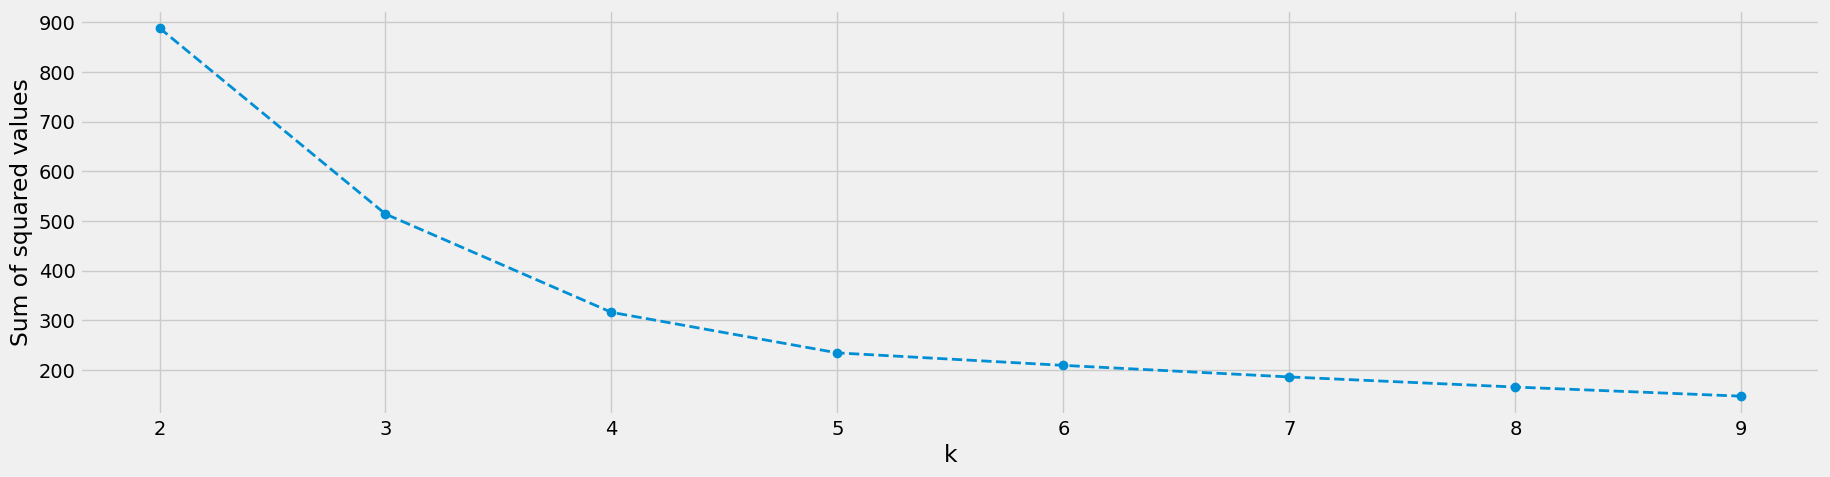

In [46]:
plt.plot(k_values , inertias , '--o' ) 
plt.xlabel("k")
plt.ylabel("Sum of squared values")

In [47]:
# So the 5 or 6 is the optimal number


kmeans = KMeans(n_clusters = 5  , n_init=20 , random_state=0)
subset = df_cluster[cluster_col]
df_cluster['cluster'] = kmeans.fit_predict(subset)


In [48]:
df_cluster

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14,cluster
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:08.000,-0.172350,0.909033,-0.168556,-27.895242,-10.831760,26.285743,B,bench,heavy,30,...,0.404506,241.915837,-32.414519,17.800054,-7.090627,-23.559585,15.300362,-56.937517,-9.887314,1
2019-01-11 15:08:08.400,-0.024777,0.860474,-0.059254,-2.040040,-1.316930,1.986210,B,bench,heavy,30,...,0.376805,266.641927,-45.027971,-65.743054,-12.016695,8.716330,14.278175,5.797033,-2.207473,1
2019-01-11 15:08:08.800,-0.063378,0.997048,-0.033869,1.164754,-1.844231,-1.240332,B,bench,heavy,30,...,0.508919,262.078311,-56.234625,-30.091473,3.458370,-13.917311,-48.217504,42.767778,-11.602442,1
2019-01-11 15:08:09.200,-0.044993,0.971809,-0.038011,2.469483,-3.482648,3.563210,B,bench,heavy,30,...,0.492961,256.245567,-31.989318,69.348370,3.624009,17.424045,36.328368,26.990522,-9.999852,1
2019-01-11 15:08:09.600,-0.046925,0.911220,-0.056463,8.471911,4.745072,-8.708681,B,bench,heavy,30,...,0.363189,214.663711,-12.227055,13.687545,10.833066,6.326124,25.453064,-35.551747,-33.538487,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:26.200,0.063910,-0.952114,0.107673,-38.792016,8.810964,14.997831,E,row,medium,90,...,0.350704,368.429928,29.216316,-57.045603,10.239165,-47.609218,-37.827325,-17.620149,-36.551825,3
2019-01-20 17:33:26.600,-0.024266,-1.193314,-0.109309,-2.783290,-1.783932,6.232364,E,row,medium,90,...,0.324461,379.719977,39.879652,-21.517667,-13.542762,27.460451,82.477003,22.715838,9.757813,0
2019-01-20 17:33:27.000,-0.043276,-0.988153,-0.062545,2.032956,-4.019557,0.196986,E,row,medium,90,...,0.238607,319.521621,-34.907878,31.861740,9.784884,1.149502,-51.406834,-1.543486,0.948401,0


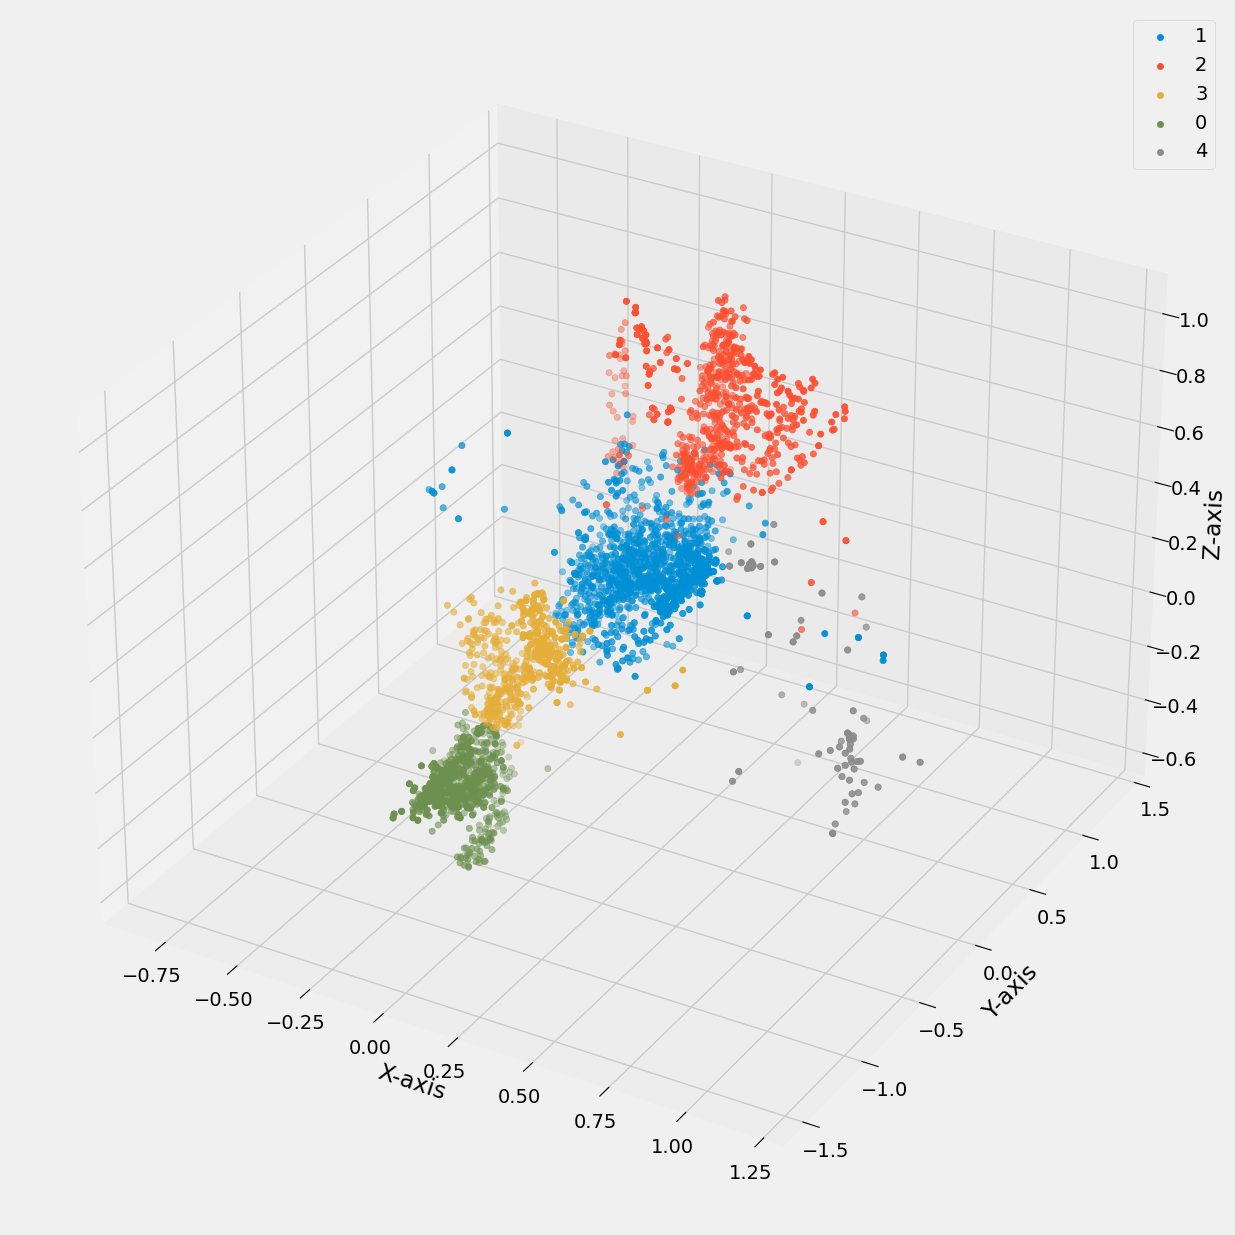

In [49]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection="3d")
for c in df_cluster["cluster"].unique():
    subset = df_cluster[df_cluster["cluster"] == c]
    ax.scatter(subset["acc_x"], subset["acc_y"], subset["acc_z"], label=c)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.legend()
plt.show()

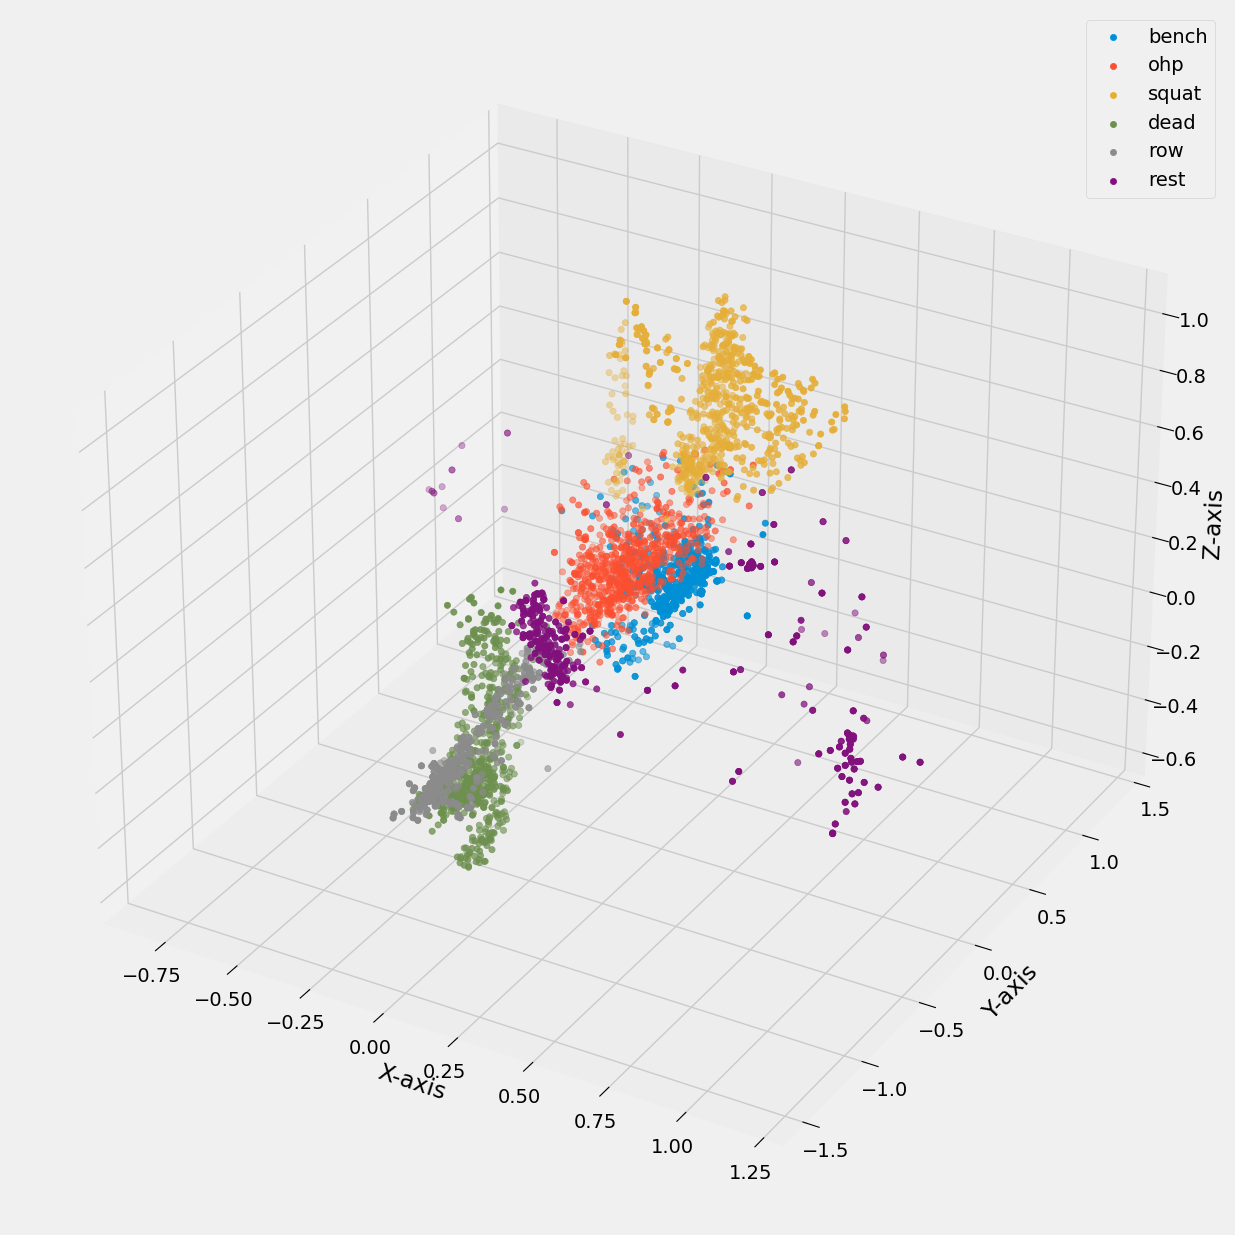

In [50]:
# Plot Labels
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection="3d")
for l in df_cluster["label"].unique():
    subset = df_cluster[df_cluster["label"] == l]
    ax.scatter(subset["acc_x"], subset["acc_y"], subset["acc_z"], label=l)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.legend()
plt.show()

In [86]:
df_cluster.to_pickle('../../data/interim/03_data_features.pkl')